In [ ]:
#importing necessary libraries 
import pandas as pd
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.parsing.preprocessing import STOPWORDS
import numpy as np
import pickle
nltk.download('stopwords')
nltk.download('wordnet')
from typing import List, Dict, Tuple, Set
import itertools
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import requests
import json
import urllib.request
import time
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import re
from sklearn.metrics.pairwise import cosine_similarity
import statistics
from datetime import datetime
from scipy.stats import skew
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading dataset

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
train_firefox_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_train_preprocessed.csv')
train_firefox_df

,Unnamed: 0,description1,description2,is_similar
0,0,created attachment fandango com after sign...,user agent mozilla gecko firefox ...,0
1,1,created attachment dropdown marker ...,user agent mozilla gecko firefox ...,1
2,3,this bug was initially created as a clon...,note i am very bad at filing bugs so i apo...,0
3,4,currently in policies we have two function ...,filed by ncsoregi at mozilla com pa...,0
4,5,remove bottom margin on image wrapper for ...,there s only a few tests remaining in browse...,0
...,...,...,...,...
31606,32441,the default light and dark themes should be...,this is happening because we have some code ...,0
31607,32442,filed by nbeleuzu at mozilla com pa...,filed by malexandru at mozilla com ...,1
31608,32443,created attachment first login is not sele...,created attachment screenshot my nightly ...,0
31609,32444,created attachment docx user agent moz...,created attachment docx user agent moz...,1


In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
test_firefox_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_test_preprocessed.csv')
test_firefox_df

,Unnamed: 0,description1,description2,is_similar
0,0,the comment in the code suggests it can be r...,bug is adding a new pinned page action o...,0
1,1,created attachment jira sidbar png user a...,automatically unloading a webrtc tab seems l...,0
2,2,created attachment reference png hi th...,filed by philringnalda at gmail com j...,0
3,3,markdown filed by rmaries at mozilla ...,user agent mozilla gecko firefox ...,0
4,4,user agent mozilla gecko firefox ...,currently we are storing full details in t...,0
...,...,...,...,...
8162,8392,filed by egao at mozilla com parsed...,scope of this bug is to investigate and impl...,0
8163,8393,filed by malexandru at mozilla com ...,steps to reproduce open several firefo...,0
8164,8394,sanitizer jsm is intended to become our inte...,considering the impact on privacy we should...,1
8165,8395,created attachment png user agent mozi...,user agent mozilla gecko firefox ...,0


In [ ]:
# Merge train & test
# frames = [train_firefox_df, test_firefox_df]
# result = pd.concat(frames)
# result = result.sample(frac=1, random_state=1).reset_index(drop=True)
# result1 = result.copy()
# dup_df= result.copy()
# dup_df #Total train & test
dup_df = train_firefox_df.copy()
dup_df 

,Unnamed: 0,description1,description2,is_similar
0,0,created attachment fandango com after sign...,user agent mozilla gecko firefox ...,0
1,1,created attachment dropdown marker ...,user agent mozilla gecko firefox ...,1
2,3,this bug was initially created as a clon...,note i am very bad at filing bugs so i apo...,0
3,4,currently in policies we have two function ...,filed by ncsoregi at mozilla com pa...,0
4,5,remove bottom margin on image wrapper for ...,there s only a few tests remaining in browse...,0
...,...,...,...,...
31606,32441,the default light and dark themes should be...,this is happening because we have some code ...,0
31607,32442,filed by nbeleuzu at mozilla com pa...,filed by malexandru at mozilla com ...,1
31608,32443,created attachment first login is not sele...,created attachment screenshot my nightly ...,0
31609,32444,created attachment docx user agent moz...,created attachment docx user agent moz...,1


In [ ]:
FEATURES = ['description1', 'description2']
print('Description of length of the feature columns')
dup_df[FEATURES].apply(lambda col: col.str.len().describe())

Description of length of the feature columns


,description1,description2
count,31611.000000,31611.000000
mean,1110.722090,1189.035431
std,2861.916456,3099.506821
min,50.000000,50.000000
25%,280.000000,289.000000
50%,483.000000,510.000000
75%,836.000000,918.000000
max,67448.000000,67448.000000


## Train, Validation, Test Split

In [ ]:
from sklearn.model_selection import train_test_split
import random
import sklearn

In [ ]:
train_val_df = train_firefox_df.copy()
train_val_df

,Unnamed: 0,description1,description2,is_similar
0,0,created attachment fandango com after sign...,user agent mozilla gecko firefox ...,0
1,1,created attachment dropdown marker ...,user agent mozilla gecko firefox ...,1
2,3,this bug was initially created as a clon...,note i am very bad at filing bugs so i apo...,0
3,4,currently in policies we have two function ...,filed by ncsoregi at mozilla com pa...,0
4,5,remove bottom margin on image wrapper for ...,there s only a few tests remaining in browse...,0
...,...,...,...,...
31606,32441,the default light and dark themes should be...,this is happening because we have some code ...,0
31607,32442,filed by nbeleuzu at mozilla com pa...,filed by malexandru at mozilla com ...,1
31608,32443,created attachment first login is not sele...,created attachment screenshot my nightly ...,0
31609,32444,created attachment docx user agent moz...,created attachment docx user agent moz...,1


In [ ]:
 test_df = test_firefox_df.copy()
 test_df

,Unnamed: 0,description1,description2,is_similar
0,0,the comment in the code suggests it can be r...,bug is adding a new pinned page action o...,0
1,1,created attachment jira sidbar png user a...,automatically unloading a webrtc tab seems l...,0
2,2,created attachment reference png hi th...,filed by philringnalda at gmail com j...,0
3,3,markdown filed by rmaries at mozilla ...,user agent mozilla gecko firefox ...,0
4,4,user agent mozilla gecko firefox ...,currently we are storing full details in t...,0
...,...,...,...,...
8162,8392,filed by egao at mozilla com parsed...,scope of this bug is to investigate and impl...,0
8163,8393,filed by malexandru at mozilla com ...,steps to reproduce open several firefo...,0
8164,8394,sanitizer jsm is intended to become our inte...,considering the impact on privacy we should...,1
8165,8395,created attachment png user agent mozi...,user agent mozilla gecko firefox ...,0


In [ ]:
train_df, val_df = train_test_split(
  train_val_df,
  test_size=0.2,
  stratify=train_val_df.is_similar,
  random_state=13,
)

In [ ]:
train_df

,Unnamed: 0,description1,description2,is_similar
20631,21175,filed by btara at mozilla com parse...,steps to reproduce set browser proton ...,0
23683,24304,created attachment how it works link add ...,firefox will not launch after recent auto up...,0
26636,27336,we want to detect browser pinned status in o...,created attachment superscia campania edit...,0
25053,25710,change line height of the sponsored by label...,i don t have solid steps to reproduce yet h...,0
28671,29415,created attachment captura de ecrã ...,user agent mozilla gecko fire...,1
...,...,...,...,...
21085,21641,in bug we attempted to get all tests worki...,there s a bunch of stuff in this file that d...,0
9480,9727,created attachment screenshot png i looke...,user agent mozilla gecko firefox ...,0
18363,18841,after bug implements nsiquotamanagerservic...,created attachment screen shot at ...,0
8462,8691,this is because onbeforeinitialxullayout doe...,user agent mozilla gecko firefox ...,0


In [ ]:
len(val_df[val_df.is_similar.astype('bool')]) / len(val_df)

0.19136485845326587

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler 

In [ ]:
label= train_df.is_similar
type(label)

pandas.core.series.Series

In [ ]:
type(train_df)

pandas.core.frame.DataFrame

In [ ]:
sm = RandomOverSampler(random_state=42)
X_res, y_res = sm.fit_resample(X=train_df[['description1', 'description2']], y=train_df.is_similar)

In [ ]:
train_df = X_res.copy()
train_df['is_similar'] = y_res
train_df = train_df.sample(frac=1)

In [ ]:
train_df

,description1,description2,is_similar
36917,created attachment screenshot ...,created attachment screenshot of persisten...,1
9134,str configure the same self signed certi...,i have a problem with firefox beta it als...,0
492,in bug i made ci cr cc and cu to be de...,tested on firefox nightly beta ...,0
17593,currently when you enter in a fragment of a ...,filed by dluca at mozilla com parse...,0
16315,created attachment beta png just installe...,created attachment firefox quantun i run ...,1
...,...,...,...
37903,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1
10888,str open any web page having popup to be...,steps to reproduce start firefox with a...,0
32863,user agent mozilla gecko firefox ...,created attachment screenshot of the outpu...,1
30145,my info nightly id ...,user agent mozilla gecko firefox ...,1


In [ ]:
len(train_df[train_df.is_similar.astype('bool')]) / len(train_df)

0.5

In [ ]:
print(f'Train Val Test Size: {len(train_df):,} {len(val_df):,} {len(test_df):,}')

Train Val Test Size: 40,902 6,323 8,167


## Download & Prepare Embedding

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow.keras.utils as kutils
from keras.layers.preprocessing.text_vectorization import TextVectorization

## create vocabulary index

In [ ]:
from typing import List

In [ ]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 1200
EMBEDDING_DIM = 100

In [ ]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS - 2,
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [dup_df.description1, dup_df.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'info', 'the', 'task']


## Prepare Training Data

In [ ]:
def generate_batches(
  split_df: pd.DataFrame,
  batch_size=1024,
):
  steps_per_epoch = len(split_df) // batch_size
  while True:
    for i in range(steps_per_epoch):
      offset = i * batch_size
      till = offset + batch_size
      feature_batches = []
      for feature in FEATURES:
        vectorizer = descr_vectorizer
        feature_batch = vectorizer(
          split_df[feature][offset: till].to_numpy().reshape((-1, 1))
        ).numpy()
        feature_batches.append(feature_batch)


      target_batch = split_df.is_similar[offset: till].to_numpy()
      yield (
        feature_batches,
        target_batch,
      )

## Create Models

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from keras.initializers.initializers_v2 import Constant

In [ ]:
DescrEmbeddingLayer = layers.Embedding(
  input_dim=MAX_TOKENS,
  output_dim=EMBEDDING_DIM,
  name='DescrEmbeddingLayer',
)

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
  DescrConv1dLayer = layers.Conv1D(
    filters=32,
    kernel_size=kernel_size,
    activation='relu',
    name=f'DescrConv1dLayer{num}',
  )
  DescrMaxPool1dLayer = layers.MaxPool1D(
    pool_size=pool_size,
    strides=strides,
    name=f'DescrMaxPool1dLayer{num}',
  )
  return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

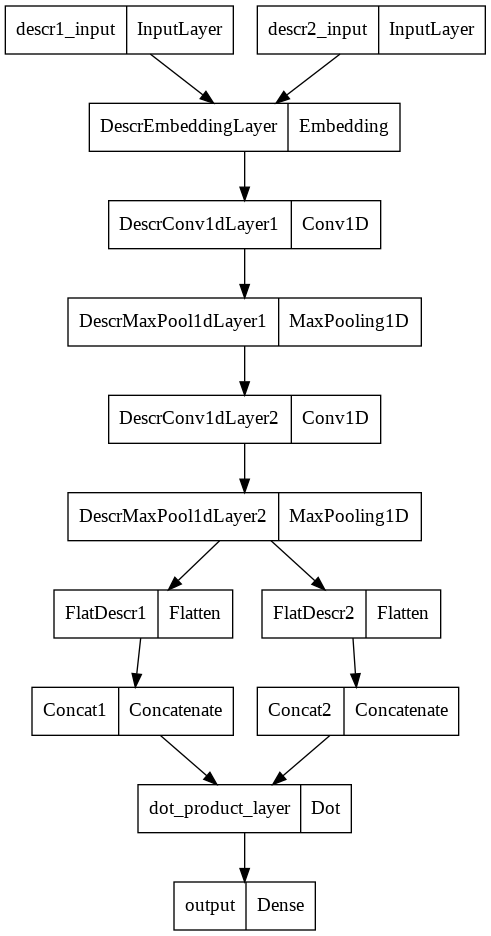

In [ ]:
def create_siamese_component(num: int):
  class SiameseComponent:
    def __init__(self, title: layers.Input, description: layers.Input, output: layers.Concatenate):
      self.title = title
      self.description = description
      self.output = output

  title_input = layers.Input(shape=(None,), dtype='int32', name=f'title{num}_input')

  descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
  descr_embedding_layer = DescrEmbeddingLayer(descr_input)
  descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
  descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
  descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
  descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
  # descr_conv1d3 = DescrConv1dLayer3(descr_max_pool1d2)
  # descr_max_pool1d3 = DescrMaxPool1dLayer3(descr_conv1d3)
  descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)
  
  concat = layers.Concatenate(axis=1, name=f'Concat{num}')([descr_flat_Layer])
  return SiameseComponent(title_input, descr_input, concat)


component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(
  axes=1,
  name='dot_product_layer'
)([component1.output, component2.output])
output = layers.Dense(
  1, activation='sigmoid', name='output',
)(dot_product_layer)
siamese_model = models.Model(
  inputs=[component1.description, component2.description],
  outputs=output,
  name='siamese_model'
)

kutils.plot_model(siamese_model)

## Train

In [ ]:
BATCH_SIZE = 2048

siamese_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['acc'],
)
callback = callbacks.ModelCheckpoint(
    filepath=f'../../drive/MyDrive/Project 6308 + ICSME/Siamese'
             '.epoch-{epoch:02d}-loss-{val_loss:.3f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min',
)

In [ ]:
history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=50,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1,
  # callbacks= [callback]
)

Epoch 1/50
19/19 [==============================] - 331s 17s/step - loss: 0.7742 - acc: 0.5063 - val_loss: 0.6960 - val_acc: 0.3571
Epoch 2/50
19/19 [==============================] - 321s 17s/step - loss: 0.6672 - acc: 0.5323 - val_loss: 0.7551 - val_acc: 0.2713
Epoch 3/50
19/19 [==============================] - 319s 17s/step - loss: 0.6201 - acc: 0.5989 - val_loss: 0.7451 - val_acc: 0.5034
Epoch 4/50
19/19 [==============================] - 317s 17s/step - loss: 0.5779 - acc: 0.6975 - val_loss: 0.7456 - val_acc: 0.5633
Epoch 5/50
19/19 [==============================] - 318s 17s/step - loss: 0.5376 - acc: 0.7400 - val_loss: 0.7572 - val_acc: 0.6045
Epoch 6/50
19/19 [==============================] - 317s 17s/step - loss: 0.4984 - acc: 0.7806 - val_loss: 0.7537 - val_acc: 0.6558
Epoch 7/50
19/19 [==============================] - 316s 17s/step - loss: 0.4626 - acc: 0.8186 - val_loss: 0.7633 - val_acc: 0.6847
Epoch 8/50
19/19 [==============================] - 314s 17s/step - loss: 0.

In [ ]:
siamese_model.save('something_firefox.hd5')

INFO:tensorflow:Assets written to: something_firefox.hd5/assets


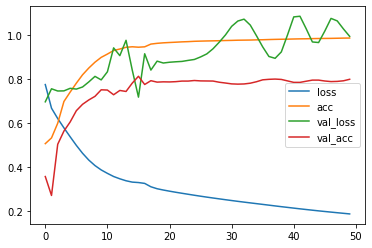

In [ ]:
ax = pd.DataFrame(history.history).plot()

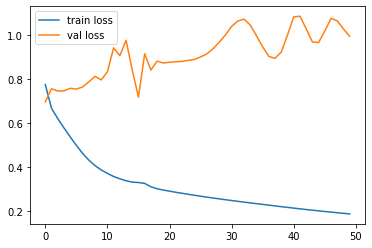

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

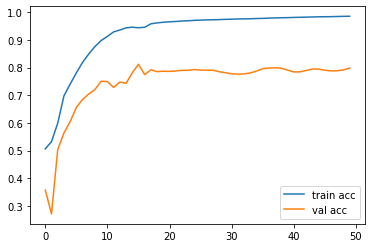

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
from sklearn.metrics import accuracy_score
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Evaluate on test data

In [ ]:
# from tensorflow.keras.models import load_model

# siamese_model = load_model('../../models/siamese-openOffice.epoch-30-loss-0.457.hdf5')

In [ ]:
siamese_model.evaluate(
  generate_batches(test_df, BATCH_SIZE),
  steps=len(test_df) // BATCH_SIZE,
)

3/3 [==============================] - 11s 3s/step - loss: 1.5139 - acc: 0.7479


[1.5139325857162476, 0.7478840947151184]

In [ ]:
len(test_df)

8167

In [ ]:
BATCH_SIZE = len(test_df)
num_batched_instances = len(test_df) - (len(test_df) % BATCH_SIZE)
pred_y = siamese_model.predict(
  generate_batches(test_df, BATCH_SIZE),
  steps=len(test_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 22s 22s/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(
  test_df.is_similar[:num_batched_instances],
  pred_y > .5,
))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      6706
           1       0.35      0.50      0.41      1461

    accuracy                           0.75      8167
   macro avg       0.62      0.65      0.63      8167
weighted avg       0.79      0.75      0.76      8167



In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  test_df.is_similar[:num_batched_instances],
  pred_y,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000000
1,0.022070,0.101300,1.000000
2,0.022666,0.103354,1.000000
3,0.022666,0.104723,1.000000
4,0.023710,0.107461,1.000000
...,...,...,...
1604,0.614524,0.839836,0.283934
1605,0.614524,0.840520,0.283934
1606,0.615568,0.840520,0.283932
1607,0.615568,0.841889,0.283932


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  test_df.is_similar[:num_batched_instances],
  pred_y,
)

print('AUROC score:', auroc)

AUROC score: 0.7061193169744093


In [ ]:
print('For probability:')
print(f'Mean: {pred_y.mean()}, STD: {pred_y.std()}')
print('For categorical:')
print(f'Mean: {(pred_y > .5).mean()}, STD: {(pred_y > .5).std()}')

For probability:
Mean: 0.4471871554851532, STD: 0.26742830872535706
For categorical:
Mean: 0.2521121586874005, STD: 0.43422530802496934


## Evaluate on textually similar data

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
sim_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_textually_similar_test_duplicates_preprocessed.csv')
sim_df

,Unnamed: 0,description1,description2,is_similar
0,0,user agent mozilla gecko firefox ...,user agent mozilla gecko buil...,1
1,1,affected versions nightly bu...,created attachment troubleshoot mode mov ...,0
2,2,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,0
3,3,created attachment ff with ellipsis menu...,created attachment screen shot at ...,1
4,4,user agent mozilla gecko firefox ...,created attachment screen shot at ...,0
...,...,...,...,...
1499,1509,user agent mozilla gecko firefox ...,let s move the library window to a tab ...,1
1500,1510,created attachment normandy events gif a...,created attachment screenshot load ...,0
1501,1511,user agent mozilla gecko firefox ...,mozilla gecko firefox id cset ...,0
1502,1512,created attachment bookmark dropdown webm ...,created attachment drop down gif affecte...,1


In [ ]:
len(sim_df)

1504

In [ ]:
sim_df = sim_df.sample(frac=1)

In [ ]:
sim_df = sim_df.sample(1420)
sim_df

,Unnamed: 0,description1,description2,is_similar
643,646,created attachment firefoxrightclick png ...,created attachment searchengine png aff...,0
1172,1181,user agent mozilla gecko firefox ...,created attachment screen shot at ...,0
155,157,created attachment screenshots png user a...,user agent mozilla gecko firefox ...,1
1017,1025,user agent mozilla gecko firefox ...,created attachment screenshot from ...,1
594,597,user agent mozilla applewebkit ...,created attachment address bar bug png us...,0
...,...,...,...,...
925,933,created attachment logonmacafterstep zip...,this bug was filed from the socorro interfac...,1
695,699,created attachment screenshot load ...,user agent mozilla gecko firefox ...,0
1413,1422,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,0
921,928,created attachment screenshot png ...,created attachment screencast issue gif ...,0


In [ ]:
BATCH_SIZE = len(sim_df)
num_batched_instances = len(sim_df) - (len(sim_df) % BATCH_SIZE)
pred_y_sim = siamese_model.predict(
  generate_batches(sim_df, BATCH_SIZE),
  steps=len(sim_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 3s 3s/step


In [ ]:
siamese_model.evaluate(
  generate_batches(sim_df, BATCH_SIZE),
  steps=len(sim_df) // BATCH_SIZE,
)

1/1 [==============================] - 3s 3s/step - loss: 2.0664 - acc: 0.5352


[2.066433906555176, 0.5352112650871277]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim > .5,
))

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       709
           1       0.53      0.56      0.55       711

    accuracy                           0.54      1420
   macro avg       0.54      0.54      0.53      1420
weighted avg       0.54      0.54      0.53      1420



In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000000
1,0.038082,0.105485,1.000000
2,0.040903,0.106892,1.000000
3,0.043724,0.112518,1.000000
4,0.045134,0.113924,1.000000
...,...,...,...
533,0.847673,0.880450,0.283961
534,0.847673,0.881857,0.283951
535,0.849083,0.881857,0.283943
536,0.849083,0.886076,0.283932


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim,
)

print('AUROC score:', auroc)


AUROC score: 0.5706150974312585


In [ ]:
print('For probability:')
print(f'Mean: {pred_y_sim.mean()}, STD: {pred_y_sim.std()}')
print('For categorical:')
print(f'Mean: {(pred_y_sim > .5).mean()}, STD: {(pred_y_sim > .5).std()}')

For probability:
Mean: 0.6183916330337524, STD: 0.30767619609832764
For categorical:
Mean: 0.5232394366197183, STD: 0.4994596365929864


## Evaluate on textually dissimilar data

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
dissim_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_textually_dissimilar_test_duplicates_preprocessed.csv')
dissim_df

,Unnamed: 0,description1,description2,is_similar
0,0,user agent mozilla gecko firefox ...,created attachment screen shot at ...,1
1,1,open the general tab in preferences scrol...,according to the design spec we would li...,1
2,2,hook up the sidebar switcher to the history ...,user agent mozilla gecko firefox ...,0
3,3,created attachment firefox profi...,created attachment screen capture wmv ste...,1
4,4,filed by wkocher at mozilla com job i...,central as beta simulation jobs repo tr...,0
...,...,...,...,...
1452,1495,created attachment troubleshooting info an...,user agent mozilla gecko firefox ...,1
1453,1496,bug was originally filed for favicons fal...,in each new window that i open the bookmark...,0
1454,1497,created attachment image png the last thi...,this bug was filed from the socorro interfac...,0
1455,1498,restylesearches is brittle to unexpected dif...,bug added the browser urlbar restylesearc...,1


In [ ]:
dissim_df = dissim_df.sample(frac=1)
dissim_df = dissim_df.sample(1420)
dissim_df

,Unnamed: 0,description1,description2,is_similar
1373,1414,user agent mozilla gecko firefox ...,my info nightly id ...,0
296,305,this bug was filed from the socorro interfac...,user agent mozilla gecko firefox ...,0
1092,1124,user agent mozilla gecko firefox ...,tl dr this is the second part of atomic i o...,1
111,116,user agent mozilla gecko firefox ...,we should probably have a gitattributes fil...,1
1431,1473,filed by ccoroiu at mozilla com par...,we do a reasonable job of using mouse intera...,0
...,...,...,...,...
1239,1276,i have converted my slides to pdf and upload...,created attachment z pdf user agent ...,1
133,139,i goofed and used hard coded values for the ...,markdown filed by rmaries at mozilla ...,0
936,962,in bug we are going to be moving session h...,before doing bug i would like to rewrite ...,1
105,110,filed by csabou at mozilla com job id...,created attachment firefox profi...,0


In [ ]:
BATCH_SIZE = len(dissim_df)
num_batched_instances = len(dissim_df) - (len(dissim_df) % BATCH_SIZE)
pred_y_dis = siamese_model.predict(
  generate_batches(dissim_df, BATCH_SIZE),
  steps=len(dissim_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 3s 3s/step


In [ ]:
siamese_model.evaluate(
  generate_batches(dissim_df, BATCH_SIZE),
  steps=len(dissim_df) // BATCH_SIZE,
)

1/1 [==============================] - 2s 2s/step - loss: 1.2458 - acc: 0.6113


[1.245789647102356, 0.611267626285553]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis > .5,
))

              precision    recall  f1-score   support

           0       0.58      0.78      0.67       711
           1       0.67      0.44      0.53       709

    accuracy                           0.61      1420
   macro avg       0.63      0.61      0.60      1420
weighted avg       0.63      0.61      0.60      1420



In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000000
1,0.028129,0.100141,1.000000
2,0.028129,0.105783,1.000000
3,0.029536,0.105783,1.000000
4,0.030942,0.108604,1.000000
...,...,...,...
459,0.599156,0.801128,0.283940
460,0.599156,0.802539,0.283940
461,0.601969,0.802539,0.283936
462,0.601969,0.803949,0.283936


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis,
)

print('AUROC score:', auroc)


AUROC score: 0.6644319865740659


In [ ]:
print('For probability:')
print(f'Mean: {pred_y_dis.mean()}, STD: {pred_y_dis.std()}')
print('For categorical:')
print(f'Mean: {(pred_y_dis > .5).mean()}, STD: {(pred_y_dis > .5).std()}')

For probability:
Mean: 0.4984337091445923, STD: 0.294564813375473
For categorical:
Mean: 0.3274647887323944, STD: 0.46928839840000597
